# Wasnik, Riya
# 1001-163-569
# 2017-03-20
# Assignment_03_01

In [ ]:
#Task1
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt 
import json

def create_rectangular_filters(N=24,min_max_size=10, max_max_size=16):
    """ This function uses the five base rectangular filters and
    creates all the possible different size and position filters
    inside an N by N area. The output of this function is a list of
    dictionaries. Each dictionary represents a rectangular filter
    at a particular position (x,y) and a particular width and Height.
    Note: the value of threshold for all the filters is set to zero.
    This value is just a place holder. The value of alpha for all the
    filters is set to 1. This is just a place holder to be used for Adaboost
    Farhad Kamangar Feb. 13, 2017"""
    FeatureTypes = [(1, 2),(2, 1),(1, 3),(3, 1), (2, 2)]
    rectangular_filters = []
    for current_feature in FeatureTypes:
        for height in range(current_feature[0], N+1, current_feature[0]):
            for width in range(current_feature[1], N+1, current_feature[1]):
                if max(height,width) >= min_max_size and max(height,width) <= max_max_size:
                    for x in range(N - width+1):
                        for y in range(N - height+1):
                            temp_dict={"type":current_feature,"position":(x,y),"width":width,"height":height,"threshold":0,"alpha":1}
                            rectangular_filters.append(temp_dict)
    return rectangular_filters

def readimages(faces_path,nonfaces_path,image_list_faces,image_list_nonfaces):
    for filename in glob.glob(faces_path):
        im=Image.open(filename)   
        im= np.asarray(im,dtype=float)/255.0 
        #im= np.cumsum(im, axis=0, out=im)
        #im= np.cumsum(im, axis=1, out=im)
        if(len(image_list_faces)<500):
            image_list_faces.append(im)
        #image_list_faces = res[:2000] 
    #print(image_list_faces )
    
    for filename in glob.glob(nonfaces_path):
        im=Image.open(filename)   
        im = im.convert('L')
        im= np.asarray(im,dtype=float)/255.0 
        #im= np.cumsum(im, axis=0, out=im)
        #im= np.cumsum(im, axis=1, out=im)
        divide1 =  np.array_split(im, im.shape[0]/24)
        for a in divide1:
            if len(image_list_nonfaces)<500:
                image_list_nonfaces.extend(np.array_split(a,a.shape[1]/24, axis=1))

def train_adaboost_face_detection(rectangular_filters,faces_path,nonfaces_path,max_classifier):
    image_list_faces = []
    image_list_nonfaces = []
    readimages(faces_path,nonfaces_path,image_list_faces,image_list_nonfaces)
    image_list_nonfaces  = image_list_nonfaces[:500]
    wt_faces = np.ones(500)
    wt_nonfaces = np.ones(500)
    Z = np.sum(wt_faces) + np.sum(wt_nonfaces)
    wt_faces = wt_faces/Z
    wt_nonfaces = wt_nonfaces/Z
    best_threshold = []
    classifiers =[]
    for itr in range(0,max_classifier):  #for each round of boosting
        best_error = []
        #best_error = np.asarray(best_error)
        best_errorabs = []
        Res = []
        #best_errorabs = np.asarray(best_errorabs)
        for filter_index in range(0,len(rectangular_filters)):
            #print("Alive")
            h=rectangular_filters[filter_index ]['height']
            w=rectangular_filters[filter_index ]['width']
            current_filter = np.ones((h,w))
            if rectangular_filters[filter_index ]['type'][0] == 1 and rectangular_filters[filter_index ]['type'][1] ==2:  #type 1,2
                for i in range(0,h):
                    for j in range(0,int(w/2)):
                        current_filter[i][j] =-1
            elif rectangular_filters[filter_index ]['type'][0] == 2 and rectangular_filters[filter_index ]['type'][1] ==1: #type 2,1
                for i in range(0,int(h/2)):
                    for j in range(0,w):
                        current_filter[i][j] =-1
            elif rectangular_filters[filter_index ]['type'][0] == 3 and rectangular_filters[filter_index ]['type'][1] ==1:  #type 3,1
                for i in range(0,int(h/3)):
                    for j in range(0,w):
                        current_filter[i][j] =-1
                for i in range(2*int(h/3),h):
                    for j in range(0,w):
                        current_filter[i][j] =-1
            elif rectangular_filters[filter_index ]['type'][0] == 1 and rectangular_filters[filter_index ]['type'][1] ==3:  #type 1,3
                for i in range(0,h):
                    for j in range(0,int(w/3)):
                        current_filter[i][j] =-1
                for i in range(0,h):
                    for j in range(2*int(w/3),w):
                        current_filter[i][j] =-1
            elif rectangular_filters[filter_index ]['type'][0] == 1 and rectangular_filters[filter_index ]['type'][1] ==3:  #type 2,2
                for i in range(0,int(h/2)):
                    for j in range(0,int(w/2)):
                        current_filter[i][j] =-1
                for i in range(int(h/2),h):
                    for j in range(int(w/2),w):
                        current_filter[i][j] =-1

            x_position = rectangular_filters[filter_index ]['position'][0]
            y_position = rectangular_filters[filter_index ]['position'][1]

            #print(p)
            filter_times_faces = []
            for image in image_list_faces:
                image_extract =  image[y_position:(y_position+h),x_position:(x_position + w)]
                value = np.sum(image_extract*current_filter)   
                filter_times_faces.append(value)
            #print(len(filter_times_faces))

            filter_times_nonfaces = []
            for image in image_list_nonfaces:
                image_extract =  image[y_position:(y_position+h),x_position:(x_position + w)]
                value = np.sum(image_extract*current_filter)   
                filter_times_nonfaces.append(value)

            filter_times_faces = np.asarray(filter_times_faces)
            result_faces = np.zeros(len(filter_times_faces))
            filter_times_nonfaces = np.asarray(filter_times_nonfaces)
            result_nonfaces =np.zeros(len(filter_times_nonfaces))
            error = []
            r={}
            if itr == 0:
                max_value = current_filter[current_filter > 0].sum()
                min_value = current_filter[current_filter < 0].sum()
                p= np.linspace(max_value, min_value, 20)   #p has 20 thresholds
                for threshold_values in p:
                    result_faces[filter_times_faces > threshold_values] = 1
                    result_nonfaces[filter_times_nonfaces < threshold_values] = 1
                    X=np.append(result_faces,result_nonfaces)
                    #print(len(X))
                    r[threshold_values]=X
                    W=np.append(wt_faces,wt_nonfaces)
                    e = np.sum(X*W)
                    error.append(e)
                error = np.asarray(error)
                error_abs = np.abs(error-0.5)
                #print(error_abs)
                d = error_abs[ np.where( error_abs < 0.5 ) ]
                error_index = np.argmax(d)
                #print("E",error_abs,filter_index,itr)
                #print("EI",error_index)
                #print(error_abs[error_index])
                best_error.append(error[error_index])
                best_errorabs.append(error_abs[error_index])
                best_threshold.append(p[error_index])
                Res.append(r[p[error_index]])
                #print("error_index",error_index)
                rectangular_filters[filter_index]['threshold'] = p[error_index]
            else:
                result_faces[filter_times_faces > best_threshold[filter_index] ]= 1
                result_nonfaces[filter_times_nonfaces < best_threshold[filter_index]] = 1
                X=np.append(result_faces,result_nonfaces)
                W=np.append(wt_faces,wt_nonfaces)
                e = np.sum(X*W)
                best_error.append(e)
                error_abs = np.abs(e-0.5)
                #print("#",error_abs)
                #d = error_abs[ np.where( error_abs < 0.5 ) ]
                #error_index = np.argmax(d)
                if(error_abs < 0.5 ):
                    best_errorabs.append(error_abs)
                else:
                    best_errorabs.append(0)
                Res.append(X)
                
        #print(best_errorabs[0])
        #print(best_error)
        #best_errorabs = np.asarray(best_errorabs)
        #print(best_errorabs)
        #dd = best_errorabs[  np.where(best_errorabs) < 0.5  ]
        #select_error_index = np.argmax(dd)
        select_error_index = np.argmax(best_errorabs) 
        #print(best_error)
        selected_best_error = best_error[select_error_index]
        #print("E",selected_best_error )
        selected_filter = rectangular_filters[ select_error_index  ]
         
        alpha = 0.5*(np.log((1-(selected_best_error))/(selected_best_error)))
        #print("S",alpha)
        rectangular_filters[select_error_index]['alpha'] = alpha
        
        classifiers.append(rectangular_filters[select_error_index])
        
        #t = rectangular_filters[select_error_index]['threshold']
        resultsToCompare = Res[select_error_index]
        for v in range(0,int(len(resultsToCompare)/2)):
            if resultsToCompare[v] ==1:
                wt_faces[v]= wt_faces[v]*np.exp(alpha)
            elif resultsToCompare[v] ==0:
                wt_faces[v] = wt_faces[v]*np.exp(-1*alpha)
        w=0
        for v in range(int(len(resultsToCompare)/2), len(resultsToCompare)):
            if resultsToCompare[v] ==1:
                wt_nonfaces[w]= wt_nonfaces[w]*np.exp(alpha)
            elif resultsToCompare[v] ==0:
                wt_nonfaces[w] = wt_nonfaces[w]*np.exp(-1*alpha)
            w= w+1
            
        Z = np.sum(wt_faces) + np.sum(wt_nonfaces)
        wt_faces = wt_faces/Z
        wt_nonfaces = wt_nonfaces/Z
        #print(wt_faces)
        #print(wt_nonfaces)
        #print(rectangular_filters[select_error_index])
        with open('last_run_500.json', 'a') as outfile:
            json.dump(rectangular_filters[select_error_index], outfile)
        del rectangular_filters[select_error_index]
        
        
    print(classifiers)

if __name__ == "__main__":
    rectangular_filters=create_rectangular_filters(24)
    print("total number of filters = ", len(rectangular_filters) )
    #print(rectangular_filters)
    faces_path='Faces/Training_faces/*'
    nonfaces_path='Faces/Training_nonfaces/*'
    max_classifier=200
    train_adaboost_face_detection(rectangular_filters,faces_path,nonfaces_path,max_classifier )

1


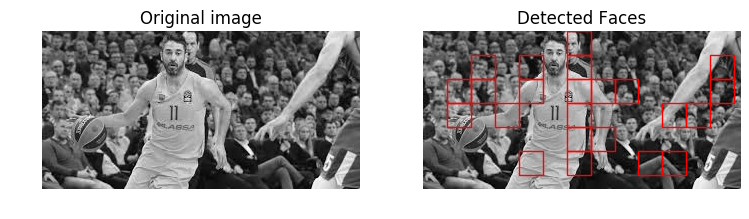

In [120]:
#Task 2
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import json
from scipy.misc import imresize


def calcascade(subwindow,selectedfilters):
    wt =0
    for filters in selectedfilters:
        h=filters['height']
        w=filters['width']
        current_filter = np.ones((h,w))
        if filters['type'][0] == 1 and filters['type'][1] ==2:  #type 1,2
                for i in range(0,h):
                    for j in range(0,int(w/2)):
                        current_filter[i][j] =-1
        elif filters['type'][0] == 2 and filters['type'][1] ==1: #type 2,1
            for i in range(0,int(h/2)):
                for j in range(0,w):
                    current_filter[i][j] =-1
        elif filters['type'][0] == 3 and filters['type'][1] ==1:  #type 3,1
            for i in range(0,int(h/3)):
                for j in range(0,w):
                    current_filter[i][j] =-1
            for i in range(2*int(h/3),h):
                for j in range(0,w):
                    current_filter[i][j] =-1
        elif filters['type'][0] == 1 and filters['type'][1] ==3:  #type 1,3
            for i in range(0,h):
                for j in range(0,int(w/3)):
                    current_filter[i][j] =-1
            for i in range(0,h):
                for j in range(2*int(w/3),w):
                    current_filter[i][j] =-1
        elif filters['type'][0] == 1 and filters['type'][1] ==3:  #type 2,2
            for i in range(0,int(h/2)):
                for j in range(0,int(w/2)):
                    current_filter[i][j] =-1
            for i in range(int(h/2),h):
                for j in range(int(w/2),w):
                    current_filter[i][j] =-1
        x_position = filters['position'][0]
        y_position = filters['position'][1]
        image_extract =  subwindow[y_position:(y_position+h),x_position:(x_position + w)]
        #print(image_extract)
        value = np.sum(image_extract*current_filter)  
        wt = wt + value*filters['alpha']
    if wt < 0:
        result = 0
    else:
        result = 1
    return result


testimage_list = []
def find_and_display_faces(test_path, classifiers_list):
    for filename in glob.glob(test_path):
        im=Image.open(filename)   
        im = im.convert('L')
        im= np.asarray(im,dtype=float)/255.0 
        #im= np.cumsum(im, axis=0, out=im)
        #im= np.cumsum(im, axis=1, out=im)
        testimage_list.append(im)
    print(len(testimage_list))
   
    
    for image in testimage_list:
        #i = image.copy()  #
        #for num in range(0,8):#
            bound =[]
            divide1 =  np.array_split(image, image.shape[0]/24)
            i=0
            for a in divide1:
                subwindow = np.array_split(a,a.shape[1]/24, axis=1)
                j =0
                for s in subwindow:
                    #print(s[0][0])
                    #k = np.argwhere(image==s[0][0])
                    #print(k)
                    #plt.imshow(s,cmap=plt.cm.gray)
                    #plt.show()
                    coord=[]
                    stage1= calcascade(s, classifiers_list[:2])
                    if stage1 == 1:
                        stage2= calcascade(s, classifiers_list[3:12])
                        if stage2 == 1: 
                            stage3 = calcascade(s, classifiers_list[13:20])
                            if stage3 ==1:
                                stage4 = calcascade(s,classifiers_list[21:40])
                                if stage4 ==1:
                                    stage5=calcascade(s,classifiers_list[41:70])
                                    if stage5 ==1:
                                        stage6=calcascade(s,classifiers_list[71:150])
                                        if stage6 ==1:
                                            stage7=calcascade(s,classifiers_list[151:200])
                                            if stage7==1:
                                                coord.append(i)
                                                coord.append(j)
                                                bound.append(coord)
                    j=j+24
                i=i+24
        
            fig1, axes_array = plt.subplots(1,2)
            fig1.set_size_inches(9,3)
            image_plot = axes_array[0].imshow(image ,cmap=plt.cm.gray) # Show the original image
            axes_array[0].axis('off')
            axes_array[0].set(title='Original image')
            image_plot = axes_array[1].imshow(image ,cmap=plt.cm.gray) # Show the original image      
            axes_array[1].axis('off')
            axes_array[1].set(title='Detected Faces')
            for v in bound:
                x = v[0]
                y = v[1]
                rect = patches.Rectangle((y,x),24,24,linewidth=1,edgecolor='r',facecolor='none')
            # Add the patch to the Axes

                axes_array[1].add_patch(rect)
            plt.show()
        
   
    

if __name__ == "__main__":
    with open('Wasnik_03_02.json') as jsond_file:
        y = json.load(jsond_file)
        faces_path='Faces/Test/*'
        find_and_display_faces(faces_path, y)
 